In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import warnings
warnings.filterwarnings('ignore')

get_ipython().run_line_magic('matplotlib', 'notebook')
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# 
class importTickerData:
    def __init__(self, ticker, start_data):
        self.ticker = ticker
        self.start_data = start_data
    
    def importData(self):
        exp = 3
        dexp = 3
        now = datetime.date.today()+datetime.timedelta(days=1)
        today = now.strftime("%Y-%m-%d")
        data = yf.download("{}".format(self.ticker), start="{}".format(self.start_data), end=today, interval = "1d", progress=False)
        data = data[['Open','Low','High','Close']]
        
        agg_dict = {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'}
        #data = data.resample('W').agg(agg_dict).shift(-1)
        
        def calc_RSI(series, period=14):
            delta = series.diff().dropna()
            ups = delta * 0
            downs = ups.copy()
            ups[delta > 0] = delta[delta > 0]
            downs[delta < 0] = -delta[delta < 0]
            ups[ups.index[period-1]] = np.mean( ups[:period] )
            ups = ups.drop(ups.index[:(period-1)])
            downs[downs.index[period-1]] = np.mean( downs[:period] )
            downs = downs.drop(downs.index[:(period-1)])
            rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
            return 100 - 100 / (1 + rs)
        
        #SMI
        data['RSI'] = calc_RSI(data['Close'], 14)
        data['C'] = (data['High'].rolling(10).max()+data['Low'].rolling(10).min())/2
        data['H'] = data['Close'] - data['C']
        data['HS1'] = data['H'].ewm(span=exp, adjust=False).mean()
        data['HS2'] = data['HS1'].ewm(span=dexp, adjust=False).mean()
        data['DHL2'] = ((data['High'].rolling(10).max() - data['Low'].rolling(10).min()).ewm(span=exp, adjust=False).mean()).ewm(span=dexp, adjust=False).mean()/2
        data['SMI'] = (data['HS2']/data['DHL2'])*100
        data['SIG'] = data['SMI'].ewm(span=10, adjust=False).mean()
        
        #S RSI
        data['low_N'] = (data['RSI'].rolling(14).min())
        data['high_N'] = (data['RSI'].rolling(14).max())
        data['SRSI'] = 100 * ((data['RSI'] - data['low_N']) / (data['high_N'] - data['low_N']))
        data['K'] = data.SRSI.rolling(window=3, center=False).mean().round(2)
        data['D'] = data.K.rolling(window=3, center=False).mean().round(2)
        
        data['smiSignal'] = np.where(data['SMI'] < -90, 1, 0)
        data['srsiSignal'] = np.where(np.logical_and(np.less(data.K, 1), np.less(data.D, 1)), 5, 0)
        data['rsiSignal'] = np.where(data['RSI'] < 20, 1, 0)
    
        data = data.drop(columns=['C','H','HS1','HS2','DHL2','low_N','high_N','SRSI'])
       
        data = data.dropna()
        data = data.reset_index()
    
        return data


importSMI = importTickerData("NOC", "2022-7-17")
SMI = importSMI.importData()
SMI.tail(20)

,Date,Open,Low,High,Close,RSI,SMI,SIG,K,D,smiSignal,srsiSignal,rsiSignal
79,2022-12-21,531.000000,529.780029,540.559998,538.789978,56.030113,-15.049326,-11.885707,31.34,22.74,0,0,0
80,2022-12-22,539.000000,526.380005,542.099976,531.369995,51.428521,-11.663659,-11.845335,29.16,26.47,0,0,0
81,2022-12-23,531.710022,529.880005,536.250000,534.770020,53.320334,-2.155191,-10.083490,40.57,33.69,0,0,0
82,2022-12-27,538.000000,537.000000,544.039978,541.190002,56.746107,18.968990,-4.801221,52.07,40.60,0,0,0
83,2022-12-28,543.450012,540.239990,545.369995,540.409973,56.206375,34.484326,2.341606,72.24,54.96,0,0,0
84,2022-12-29,540.219971,538.210022,544.219971,542.000000,57.102063,47.812060,10.608961,89.78,71.36,0,0,0
85,2022-12-30,542.929993,539.510010,546.869995,545.609985,59.145097,62.236645,19.995813,93.83,85.28,0,0,0
86,2023-01-03,544.919983,537.900024,547.799988,540.330017,55.017912,58.503146,26.997146,86.01,89.87,0,0,0
87,2023-01-04,535.869995,522.369995,540.349976,526.450012,45.942039,23.740823,26.405087,52.68,77.51,0,0,0
88,2023-01-05,526.530029,522.940002,533.710022,528.520020,47.337297,-4.359769,20.811477,22.87,53.85,0,0,0


<IPython.core.display.Javascript object>


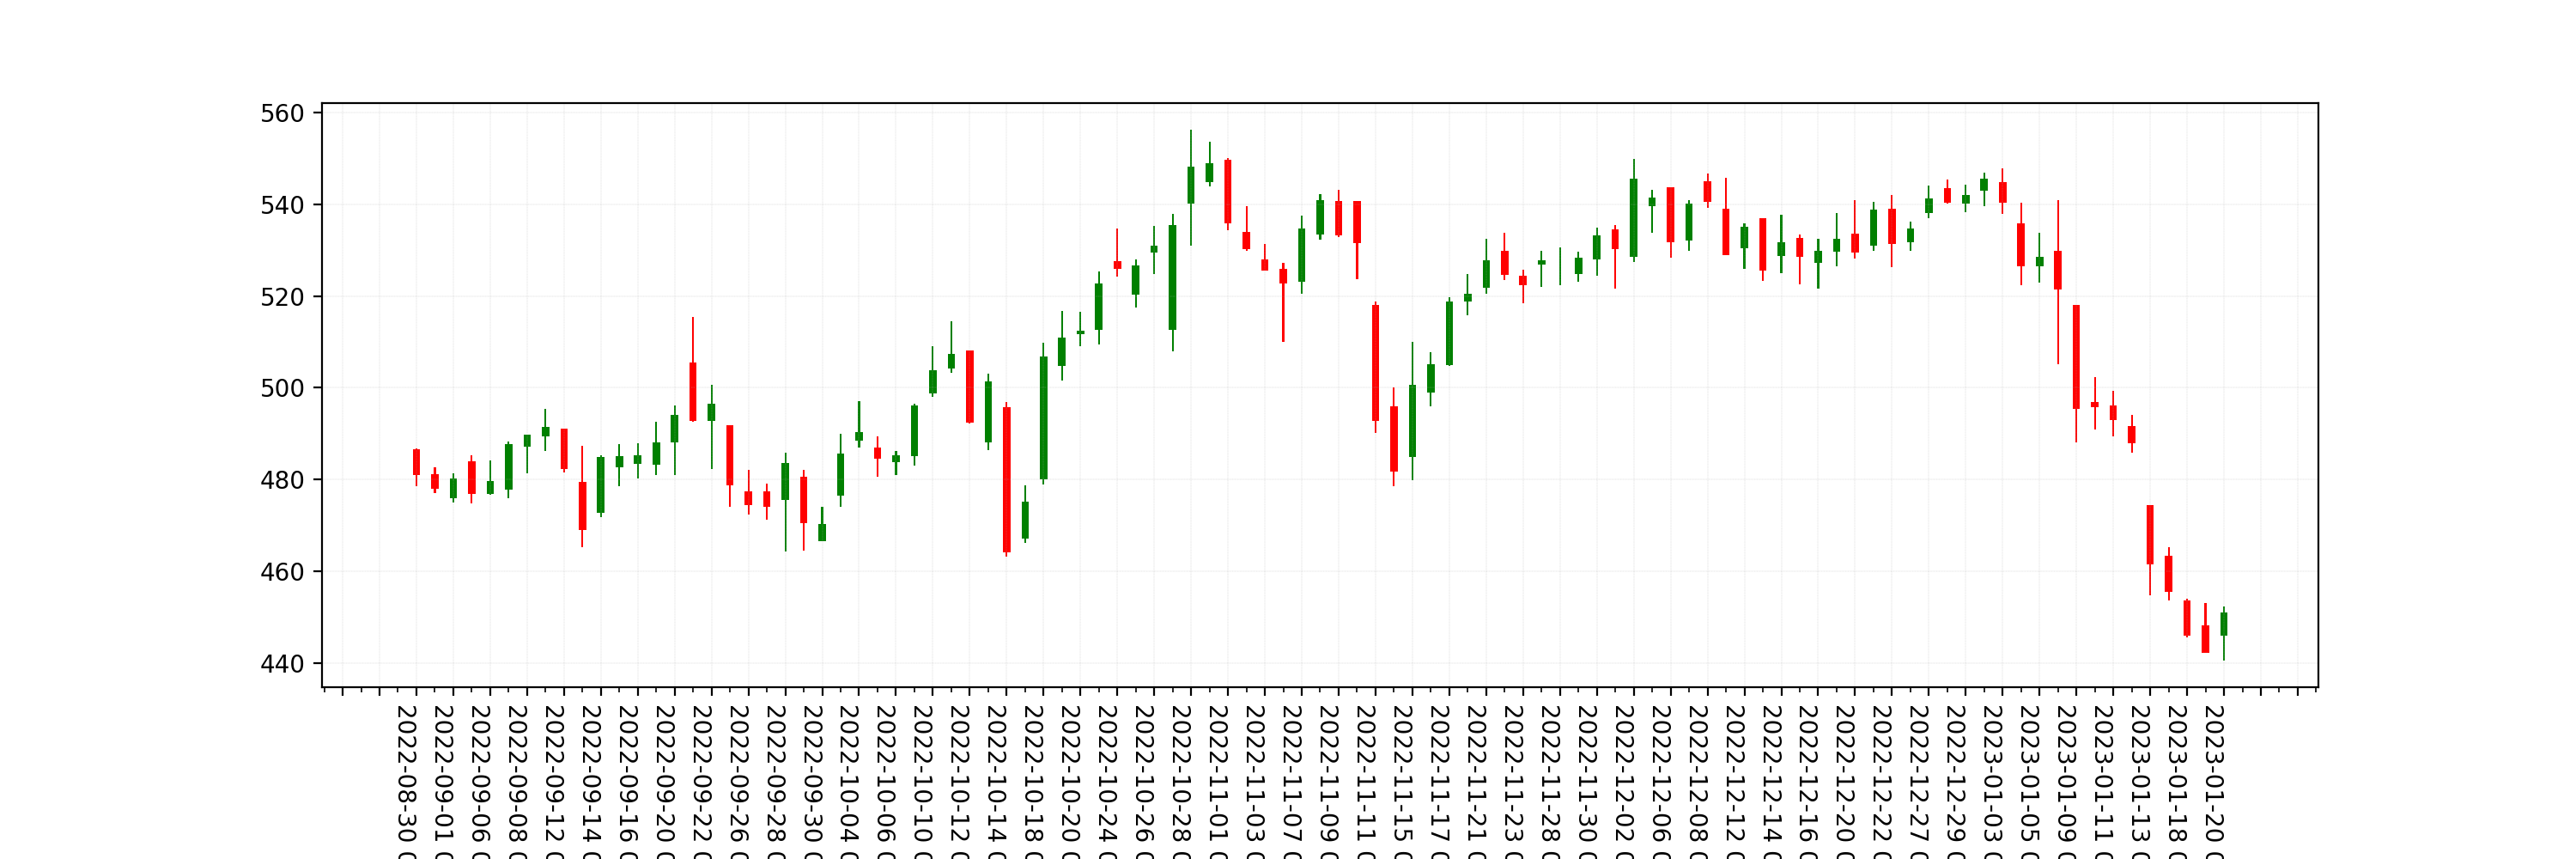

<IPython.core.display.Javascript object>


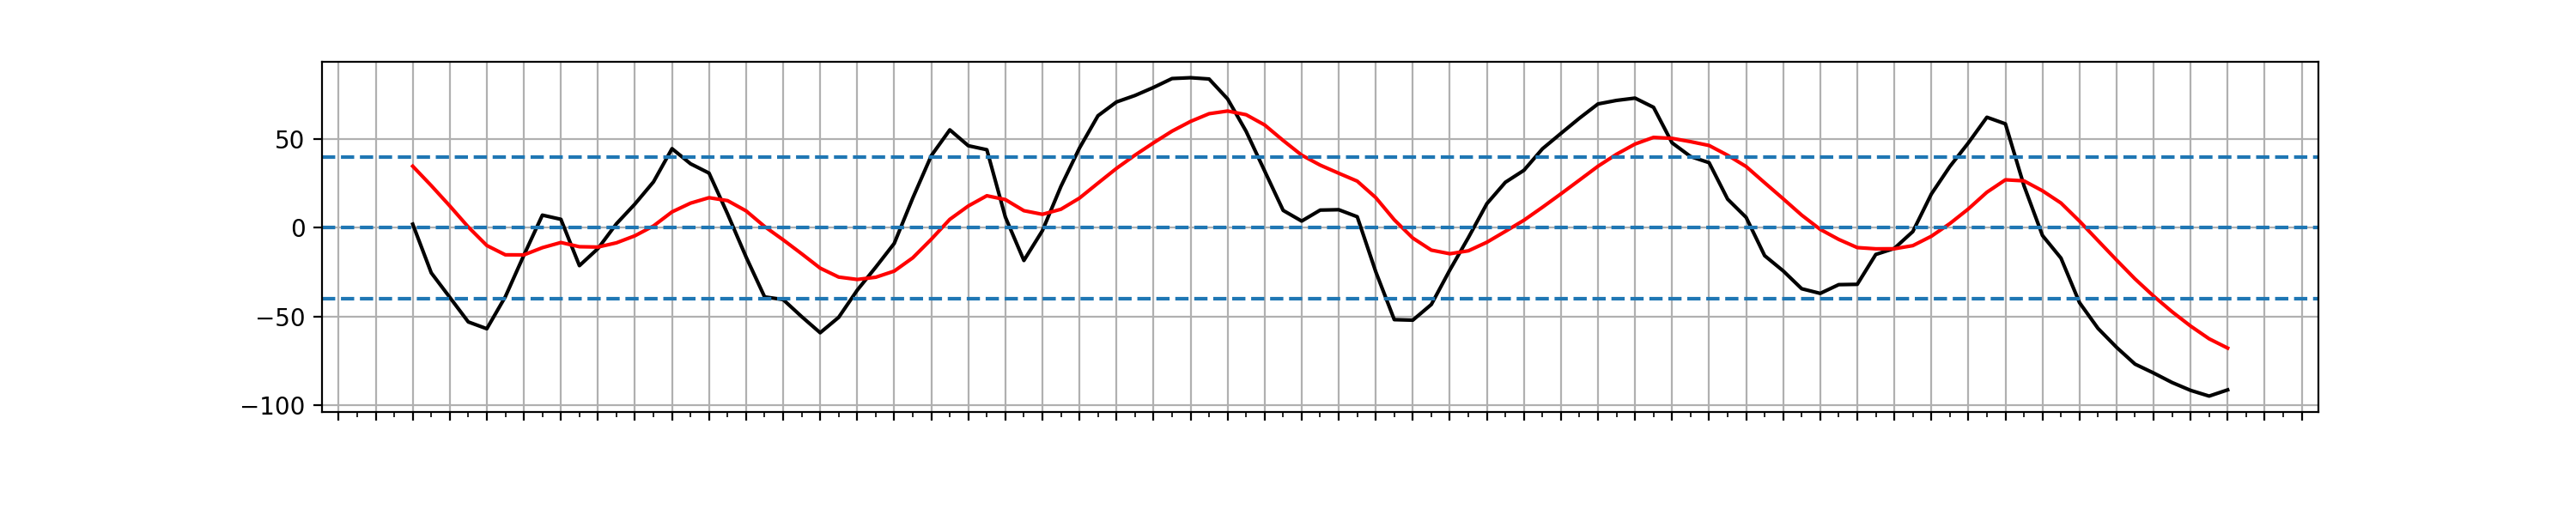

<IPython.core.display.Javascript object>


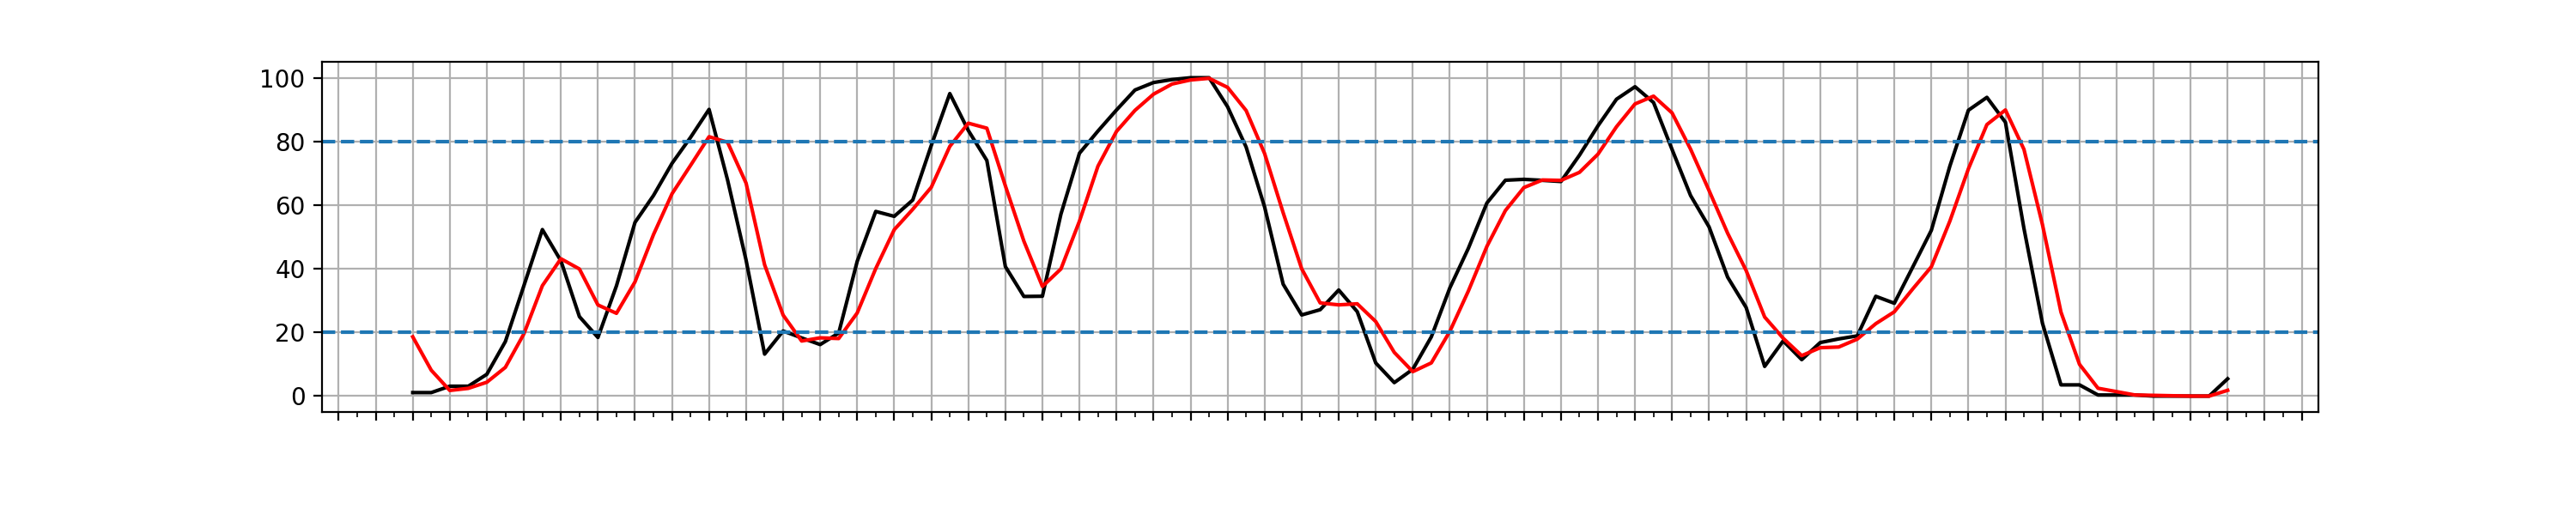

<IPython.core.display.Javascript object>


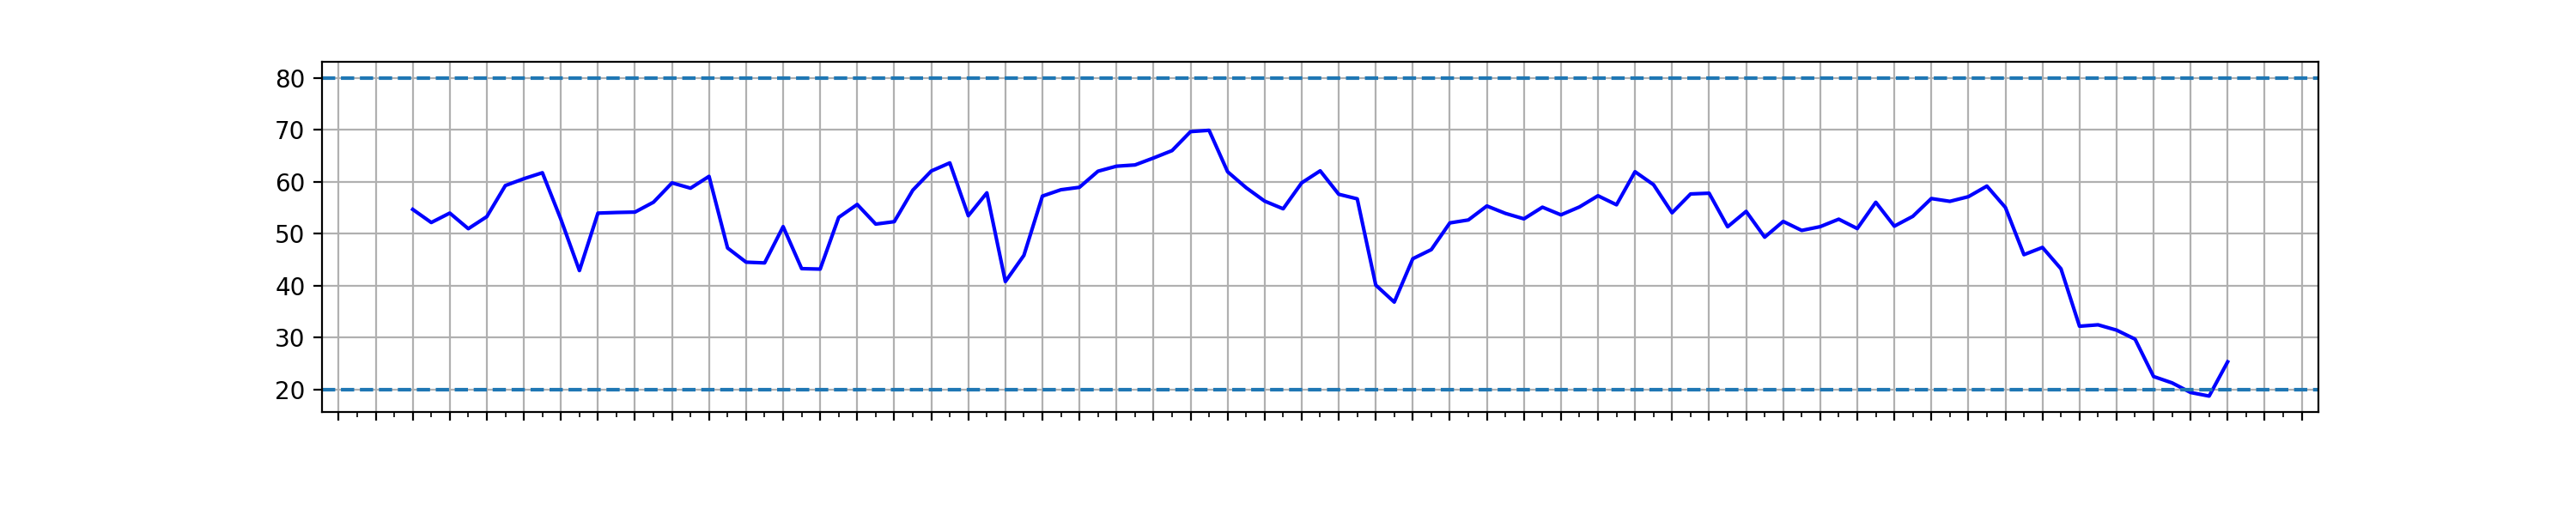

In [3]:
import matplotlib.ticker as plticker
from matplotlib.ticker import MultipleLocator


fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
ax.grid(linestyle='--', linewidth=0.1)
width = .4
width2 = .1

#define up and down prices
up = SMI[SMI.Close>=SMI.Open]
down = SMI[SMI.Close<SMI.Open]

#define colors to use
col1 = 'green'
col2 = 'red'

#plot up prices
ax.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color=col1)
ax.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color=col1)
plt.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color=col1)

#plot down prices
ax.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color=col2)
ax.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color=col2)
ax.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color=col2)

ax.set_xticks(SMI.index, labels=SMI.Date)

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))

fig.autofmt_xdate(rotation=270)




fig, ax = plt.subplots()
fig.set_size_inches(15, 3)
ax.grid()
ax.plot(SMI.index, 'SMI', data=SMI, color='black')
ax.plot(SMI.index, 'SIG', data=SMI, color='r')

ax.axhline(40, linestyle='--')
ax.axhline(0, linestyle='--')
ax.axhline(-40, linestyle='--')
ax.set_xticks(SMI.index, labels=[])

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))

fig.autofmt_xdate(rotation=270)

fig, ax = plt.subplots()
fig.set_size_inches(15, 3)
ax.grid()
ax.plot(SMI.index, 'K', data=SMI, color='black')
ax.plot(SMI.index, 'D', data=SMI, color='r')

ax.axhline(80, linestyle='--')
ax.axhline(20, linestyle='--')
ax.set_xticks(SMI.index, labels=[])
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))

fig.autofmt_xdate(rotation=270)


fig, ax = plt.subplots()
fig.set_size_inches(15, 3)
ax.grid()
ax.plot(SMI.index, 'RSI', data=SMI, color='blue')


ax.axhline(80, linestyle='--')
ax.axhline(20, linestyle='--')
ax.set_xticks(SMI.index, labels=[])
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))

fig.autofmt_xdate(rotation=270)

In [4]:
#tickers = ["AAOI", "ACCD", "ACIW", "ACLS", "ACMR", "ADBE", "ADEA", "ADI", "ADSK", "ADTN", "AFRM", "AGIL", "AGYS", "AIP", "AIRG", "AKLI", "ALGM", "ALKT", "ALRM", "ALTR", "AMAT", "AMBA", "AMD", "AMKR", "AMPL", "AMSWA", "AMWL", "AMX", "ANGI", "ANSS", "APH", "APP", "APPF", "APPN", "APPS", "ARBK", "ARLO", "ARQQ", "ARRY", "ARW", "ASGN", "ASUR", "ASYS", "ATKR", "ATNI", "ATUS", "AUGX", "AUR", "AVDX", "AVID", "AVNW", "AVPT", "AVT", "AXTI", "AYX", "AZPN", "BAND", "BASE", "BCO", "BCOV", "BDC", "BEEM", "BHE", "BIGC", "BKKT", "BKTI", "BL", "BLKB", "BLZE", "BMBL", "BNFT", "BOX", "BRC", "BRZE", "BSY", "BW", "CACI", "CALX", "CASA", "CCCS", "CCRD", "CCSI", "CDAY", "CDNS", "CERT", "CEVA", "CFLT", "CISO", "CLMB", "CLSK", "CMAX", "CMTL", "CNDT", "CNSL", "CNXC", "CNXN", "COIN", "COMM", "COUP", "CPSI", "CPTN", "CRDO", "CRM", "CRNC", "CRSR", "CRUS", "CRWD", "CSCO", "CSGS", "CTLP", "CTS", "CTSH", "CVLT", "CVT", "CYXT", "DAVA", "DAVE", "DBD", "DBX", "DCT", "DDD", "DDOG", "DFLI", "DGII", "DH", "DHX", "DIOD", "DLB", "DNB", "DOCN", "DOCU", "DOMO", "DOX", "DSP", "DT", "DUOL", "EB", "EEFT", "EGAN", "EGHT", "EGIO", "EMAN", "EMBK", "ENPH", "ENTG", "ENV", "EOSE", "EPAM", "ERIC", "ERII", "ESE", "ESTC", "EVBG", "EVCM", "EVER", "EVLV", "EVOP", "EXFY", "EXLS", "EXTR", "FFIV", "FICO", "FIVN", "FLT", "FLYW", "FORA", "FORM", "FOUR", "FROG", "FRSH", "FSLR", "FSS", "FTCI", "FTNT", "GAN", "GBTG", "GDDY", "GDRX", "GDYN", "GFS", "GIC", "GLW", "GMGI", "GTLB", "GTLS", "GWRE", "HCKT", "HCP", "HLIT", "HLTH", "HOOD", "HPE", "HPQ", "HUBB", "HUBS", "IBM", "ICHR", "IDBA", "IDCC", "III", "IIIV", "IMMR", "IMXI", "INDI", "INSE", "INSG", "INTA", "INTC", "INTT", "INTU", "INTZ", "INVE", "IPGP", "ISDR", "ITI", "IVAC", "JAMF", "JBL", "JKHY", "JNPR", "KAI", "KE", "KLAC", "KLR", "KLTR", "KNBE", "KOPN", "KPLT", "KVHI", "LASR", "LAW", "LBTYA", "LBTYK", "LDOS", "LFUS", "LIFW", "LILA", "LILAK", "LITE", "LOGI", "LPSN", "LRCX", "LSCC", "LTCH", "LTRX", "LUMN", "LVOX", "LYFT", "LYLT", "LZ", "MANH", "MAPS", "MCHP", "MDB", "MDRX", "MEI", "MG", "MIR", "MITK", "MKFG", "MKTW", "ML", "MMAT", "MNTV", "MNTX", "MODN", "MPWR", "MQ", "MRVL", "MSA", "MSI", "MSTR", "MTCH", "MTLS", "MTSI", "MTTR", "MU", "MX", "MXL", "MYPS", "NATI", "NCNO", "NET", "NEWR", "NOC", "NOK", "NOW", "NRDY", "NSIT", "NSSC", "NTAP", "NTNX", "NUTX", "NVTS", "NXPI", "OKTA", "OLED", "ON", "ONDS", "ONTO", "OPRA", "ORAN", "OSIS", "OSPN", "OSS", "OUST", "PANW", "PAR", "PAYA", "PAYO", "PAYS", "PCTY", "PCYG", "PDFS", "PEAR", "PEGA", "PET", "PHUN", "PLAB", "PLUS", "PLXS", "POWI", "PRCH", "PRFT", "PRGS", "PRO", "PRST", "PRVA", "PTC", "PUBM", "PWFL", "PWSC", "PXLW", "PYCR", "QCOM", "QLYS", "QMCO", "QUIK", "RAMP", "RBBN", "RBLX", "REKR", "RELY", "RFIL", "RGTI", "RIOT", "RMBS", "RMNI", "ROKU", "RPAY", "RPD", "RSSS", "RUM", "RXT", "S", "SANM", "SAP", "SATS", "SCPL", "SCSC", "SDGR", "SE", "SGH", "SHCR", "SHEN", "SHLS", "SITM", "SKYT", "SKYX", "SLAB", "SLP", "SMAR", "SMCI", "SMRT", "SMSI", "SMTC", "SNAP", "SNCR", "SNOW", "SNPS", "SOUN", "SPLK", "SPOK", "SPSC", "SPT", "SPWR", "SQ", "SQNS", "SRAD", "SRT", "SSNC", "SSTI", "SSTK", "SSYS", "STEM", "STER", "STIX", "STM", "STRM", "STX", "SUMO", "SURG", "SWI", "SWKS", "SYNA", "TACT", "TASK", "TDC", "TDS", "TEF", "TEL", "TENB", "TGAN", "TIGO", "TLS", "TMUS", "TPIC", "TRNS", "TRUE", "TRVG", "TTD", "TTEC", "TTGT", "TTMI", "TTWO", "TWKS", "TXN", "TYL", "U", "UCTT", "UI", "UIS", "ULBI", "UPLD", "USM", "VCSA", "VECO", "VERI", "VERX", "VIAV", "VICR", "VMEO", "VMW", "VOD", "VRNS", "VRNT", "VRSN", "VSAT", "VSH", "VUZI", "VZ", "WBD", "WDAY", "WDC", "WEX", "WGS", "WK", "WOLF", "XAIR", "XM", "XMTR", "YELP", "YEXT", "ZBRA", "ZFOX", "ZI", "ZM", "ZS"]
tickers = ["AADI", "AAL", "AAOI", "AAON", "AAWW", "ABCB", "ABCL", "ABCM", "ABEO", "ABNB", "ABOS", "ABSI", "ABUS", "ABVC", "ACAD", "ACB", "ACCD", "ACDC", "ACER", "ACET", "ACHC", "ACHL", "ACHV", "ACIU", "ACIW", "ACLS", "ACLX", "ACMR", "ACON", "ACRS", "ACRV", "ACRX", "ACST", "ACT", "ACVA", "ACXP", "ADAP", "ADBE", "ADEA", "ADI", "ADIL", "ADMA", "ADN", "ADP", "ADPT", "ADSE", "ADSK", "ADTH", "ADTN", "ADTX", "ADUS", "ADV", "ADVM", "ADXN", "AEHR", "AEIS", "AEP", "AEYE", "AEZS", "AFIB", "AFMD", "AFRM", "AGEN", "AGFY", "AGIL", "AGIO", "AGLE", "AGRX", "AGYS", "AHCO", "AIMC", "AIP", "AIRG", "AIRS", "AKAM", "AKBA", "AKLI", "AKRO", "AKTS", "AKTX", "AKU", "AKYA", "ALBO", "ALDX", "ALEC", "ALGM", "ALGN", "ALGS", "ALGT", "ALHC", "ALIM", "ALKS", "ALKT", "ALLK", "ALLO", "ALLR", "ALNY", "ALPN", "ALR", "ALRM", "ALRN", "ALRS", "ALT", "ALTO", "ALTR", "ALVO", "ALVR", "ALXO", "AMAL", "AMAT", "AMBA", "AMCX", "AMD", "AMED", "AMEH", "AMGN", "AMKR", "AMLX", "AMNB", "AMOT", "AMPG", "AMPH", "AMPL", "AMRK", "AMRN", "AMRS", "AMSC", "AMSF", "AMSWA", "AMTB", "AMTI", "AMTX", "AMV", "AMWD", "AMYT", "ANAB", "ANDE", "ANEB", "ANGI", "ANGN", "ANGO", "ANIK", "ANIP", "ANIX", "ANNX", "ANSS", "ANTX", "APA", "APDN", "APEI", "APEN", "APGN", "APLD", "APLS", "APLT", "APP", "APPF", "APPH", "APPN", "APPS", "APRE", "APTO", "APTX", "APVO", "APYX", "AQMS", "AQST", "ARAV", "ARAY", "ARBK", "ARCB", "ARCC", "ARDS", "ARDX", "AREB", "ARGX", "ARHS", "ARKO", "ARLP", "AROW", "ARQQ", "ARQT", "ARRY", "ARTL", "ARTNA", "ARVL", "ARVN", "ARWR", "ASAP", "ASLE", "ASMB", "ASND", "ASO", "ASPS", "ASPU", "ASRT", "ASTE", "ASTS", "ASUR", "ASYS", "ATAI", "ATCX", "ATEC", "ATEX", "ATHA", "ATLC", "ATNF", "ATNI", "ATNX", "ATOS", "ATRA", "ATRC", "ATRO", "ATSG", "ATVI", "ATXS", "AUGX", "AUPH", "AUR", "AURA", "AUTL", "AUUD", "AVAH", "AVAV", "AVDL", "AVDX", "AVID", "AVIR", "AVNW", "AVO", "AVPT", "AVRO", "AVT", "AVTE", "AVTX", "AVXL", "AWH", "AXDX", "AXGN", "AXLA", "AXNX", "AXON", "AXSM", "AXTI", "AY", "AYTU", "AZPN", "AZTA", "AZYO", "BAND", "BANF", "BANR", "BASE", "BATRK", "BBCP", "BBGI", "BBIO", "BBLG", "BBSI", "BCAB", "BCBP", "BCDA", "BCEL", "BCLI", "BCML", "BCOR", "BCOV", "BCPC", "BCRX", "BCTX", "BCYC", "BDSX", "BDTX", "BEAM", "BEAT", "BECN", "BEEM", "BFC", "BFIN", "BFRI", "BFST", "BGCP", "BGRY", "BHF", "BIGC", "BIIB", "BIOC", "BIOL", "BIOR", "BIRD", "BIVI", "BJDX", "BJRI", "BKNG", "BKR", "BKYI", "BL", "BLBD", "BLBX", "BLCM", "BLDE", "BLFS", "BLFY", "BLI", "BLIN", "BLKB", "BLMN", "BLNK", "BLPH", "BLTE", "BLU", "BLUE", "BLZE", "BMBL", "BMEA", "BMRC", "BMRN", "BNFT", "BNGO", "BNOX", "BNTC", "BNTX", "BOKF", "BOLT", "BOXL", "BPMC", "BPOP", "BPRN", "BPTH", "BPTS", "BRFH", "BRKL", "BRKR", "BRLT", "BRTX", "BRY", "BRZE", "BSET", "BSFC", "BSGM", "BSRR", "BSVN", "BSY", "BTAI", "BTBT", "BTCS", "BTCY", "BTMD", "BTTX", "BUSE", "BVS", "BWB", "BWEN", "BWMN", "BWMX", "BWV", "BXRX", "BYND", "BYRN", "BZFD", "CABA", "CAC", "CACC", "CADL", "CAKE", "CALA", "CALB", "CALM", "CALT", "CAMP", "CAPR", "CAR", "CARA", "CARE", "CASA", "CASH", "CASI", "CASS", "CATC", "CATY", "CBAN", "CBAY", "CBFV", "CBIO", "CBNK", "CBRL", "CBSH", "CCAP", "CCB", "CCBG", "CCCC", "CCCS", "CCEP", "CCLD", "CCLP", "CCNE", "CCOI", "CCRN", "CCSI", "CDAK", "CDIO", "CDLX", "CDMO", "CDNA", "CDNS", "CDRO", "CDTX", "CDW", "CDXC", "CDXS", "CDZI", "CECO", "CEG", "CELC", "CELH", "CELU", "CELZ", "CEMI", "CENX", "CERE", "CERS", "CERT", "CEVA", "CFB", "CFBK", "CFFN", "CFLT", "CFMS", "CFRX", "CG", "CGBD", "CGC", "CGEM", "CGNX", "CGTX", "CHCO", "CHDN", "CHEF", "CHK", "CHMG", "CHRD", "CHRS", "CHRW", "CHTR", "CHUY", "CHX", "CIDM", "CIFR", "CINC", "CINF", "CING", "CISO", "CIVB", "CKPT", "CLAR", "CLBK", "CLDX", "CLFD", "CLIR", "CLLS", "CLMB", "CLMT", "CLNE", "CLNN", "CLOV", "CLRB", "CLSD", "CLSK", "CLXT", "CMAX", "CMCO", "CMCSA", "CME", "CMLS", "CMPO", "CMPR", "CMPS", "CMPX", "CMRX", "CMTL", "CNCE", "CNDT", "CNFR", "CNOB", "CNSL", "CNSP", "CNTA", "CNTG", "CNTX", "CNTY", "CNXC", "CNXN", "COCO", "COCP", "CODX", "COEP", "COGT", "COHR", "COHU", "COIN", "COLB", "COLL", "COLM", "COMM", "COMS", "CONN", "COOP", "CORT", "COUP", "COWN", "CPLP", "CPRT", "CPRX", "CPSI", "CPTN", "CRAI", "CRBP", "CRBU", "CRDF", "CRDL", "CRDO", "CREX", "CRGE", "CRIS", "CRMD", "CRMT", "CRNC", "CRNX", "CRON", "CROX", "CRSP", "CRSR", "CRTO", "CRUS", "CRVS", "CRWD", "CSBR", "CSCO", "CSGP", "CSGS", "CSII", "CSSE", "CSTL", "CSTR", "CSWC", "CSWI", "CSX", "CTAS", "CTBI", "CTHR", "CTIC", "CTKB", "CTLP", "CTMX", "CTSH", "CTSO", "CTXR", "CUE", "CURI", "CUTR", "CVAC", "CVBF", "CVCO", "CVCY", "CVGI", "CVGW", "CVLG", "CVLT", "CVRX", "CVT", "CWBC", "CWBR", "CWST", "CXDO", "CYCC", "CYCN", "CYN", "CYT", "CYTH", "CYTK", "CYXT", "CZFS", "CZNC", "CZR", "CZWI", "DARE", "DAVE", "DAWN", "DBTX", "DBVT", "DBX", "DCGO", "DCOM", "DCPH", "DCT", "DCTH", "DDOG", "DENN", "DERM", "DFFN", "DFLI", "DGII", "DH", "DICE", "DIOD", "DISH", "DKNG", "DLHC", "DLPN", "DLTH", "DLTR", "DMAC", "DMTK", "DNLI", "DNUT", "DOCU", "DOMH", "DOMO", "DORM", "DOX", "DPRO", "DRCT", "DRMA", "DRRX", "DSEY", "DSGN", "DSGR", "DSP", "DTIL", "DUOL", "DUOT", "DVAX", "DXCM", "DXLG", "DXPE", "DXR", "DYAI", "DYN", "DYNT", "DZSI", "EA", "EAST", "EBAY", "EBC", "EBET", "EBMT", "ECOR", "EDAP", "EDBL", "EDIT", "EDRY", "EDSA", "EEFT", "EFOI", "EFSC", "EFTR", "EGAN", "EGBN", "EGHT", "EGIO", "EGRX", "EHTH", "EIGR", "EKSO", "ELDN", "ELEV", "ELOX", "ELYM", "ELYS", "EMBC", "EMBK", "EMKR", "ENPH", "ENSC", "ENSG", "ENTA", "ENTG", "ENVB", "ENVX", "EOLS", "EOSE", "EPIX", "EQ", "EQBK", "EQRX", "ERAS", "ERIC", "ERIE", "ERII", "ERNA", "ERYP", "ESEA", "ESPR", "ESQ", "ESSA", "ETNB", "ETON", "ETSY", "EVAX", "EVBG", "EVCM", "EVER", "EVGO", "EVLO", "EVLV", "EVO", "EVOP", "EVRG", "EWBC", "EWCZ", "EWTX", "EXAI", "EXAS", "EXC", "EXEL", "EXFY", "EXLS", "EXPD", "EXPE", "EXPI", "EXPO", "EXTR", "EYE", "EYEN", "EYPT", "EZFL", "FA", "FANG", "FARM", "FARO", "FAST", "FAT", "FATE", "FBIO", "FBIZ", "FBMS", "FBNC", "FBRX", "FCAP", "FCCO", "FCEL", "FCNCA", "FCRD", "FDMT", "FDUS", "FEAM", "FELE", "FEMY", "FENC", "FFBC", "FFIC", "FFIE", "FFIN", "FFIV", "FFNW", "FFWM", "FGBI", "FGEN", "FGI", "FHB", "FHTX", "FIBK", "FINW", "FIP", "FISI", "FISV", "FITB", "FIVE", "FIVN", "FIXX", "FLGC", "FLGT", "FLIC", "FLL", "FLNC", "FLNT", "FLUX", "FLWS", "FLYW", "FMAO", "FMBH", "FMNB", "FNCH", "FNKO", "FNWB", "FNWD", "FOCS", "FOLD", "FORA", "FORM", "FORR", "FOX", "FOXA", "FOXF", "FPAY", "FRBA", "FRBK", "FREQ", "FRGI", "FRGT", "FRLN", "FRME", "FROG", "FRSH", "FRST", "FRTX", "FSBC", "FSBW", "FSFG", "FSLR", "FSTR", "FSTX", "FTAI", "FTCI", "FTDR", "FTEK", "FTHM", "FTNT", "FULC", "FULT", "FUSN", "FUV", "FVCB", "FWBI", "FWONA", "FWONK", "FWRD", "FWRG", "FXNC", "FYBR", "GABC", "GAIN", "GALT", "GAMB", "GAN", "GANX", "GASS", "GBDC", "GBIO", "GCMG", "GDEN", "GDRX", "GDYN", "GECC", "GEHC", "GERN", "GEVO", "GFS", "GH", "GHRS", "GHSI", "GIII", "GILD", "GLAD", "GLBS", "GLDD", "GLPG", "GLSI", "GLTO", "GLUE", "GLYC", "GMAB", "GMGI", "GNFT", "GNSS", "GNTA", "GNTX", "GNTY", "GNUS", "GO", "GOCO", "GOGO", "GOSS", "GOVX", "GP", "GPP", "GPRE", "GPRO", "GRAY", "GREE", "GRFS", "GRNA", "GROM", "GRPH", "GRTS", "GRTX", "GRWG", "GSBC", "GSHD", "GSM", "GT", "GTBP", "GTHX", "GTLB", "GTX", "GWRS", "HA", "HAFC", "HAIN", "HALL", "HALO", "HARP", "HAS", "HBAN", "HBCP", "HBIO", "HBNC", "HBT", "HCAT", "HCCI", "HCKT", "HCP", "HCSG", "HCTI", "HCWB", "HDSN", "HEAR", "HEES", "HEPA", "HEXO", "HFWA", "HGBL", "HGEN", "HHS", "HIBB", "HLIT", "HLMN", "HLNE", "HLTH", "HLVX", "HMPT", "HMST", "HNRG", "HNST", "HNVR", "HOFV", "HOLX", "HON", "HONE", "HOOD", "HOOK", "HOPE", "HOTH", "HOWL", "HPK", "HQI", "HQY", "HRMY", "HROW", "HRTX", "HRZN", "HSCS", "HSDT", "HSIC", "HSII", "HSKA", "HSON", "HSTM", "HTBI", "HTBK", "HTGM", "HTLD", "HTLF", "HTOO", "HTZ", "HUBG", "HUMA", "HURN", "HWC", "HWKN", "HYFM", "HYPR", "HYRE", "HYZN", "HZNP", "IAC", "IART", "IAS", "IBCP", "IBKR", "IBRX", "IBTX", "ICAD", "ICFI", "ICHR", "ICLR", "ICMB", "ICPT", "ICUI", "ICVX", "IDAI", "IDBA", "IDCC", "IDEX", "IDN", "IDXX", "IDYA", "IEP", "IFRX", "IGMS", "IHRT", "III", "IIIV", "IKNA", "ILMN", "IMBI", "IMCC", "IMCR", "IMGN", "IMMR", "IMNM", "IMNN", "IMPL", "IMRA", "IMRX", "IMTX", "IMUX", "IMV", "IMVT", "IMXI", "INAB", "INBK", "INBS", "INBX", "INCY", "INDB", "INDI", "INDP", "INFI", "INFN", "INGN", "INKT", "INM", "INMB", "INNV", "INO", "INSE", "INSG", "INSM", "INTA", "INTC", "INTU", "INTZ", "INVA", "INVE", "INVO", "INZY", "IOBT", "IONM", "IONS", "IOSP", "IOVA", "IPA", "IPAR", "IPGP", "IPHA", "IPSC", "IPW", "IPWR", "IRDM", "IRIX", "IRMD", "IRON", "IRTC", "IRWD", "ISEE", "ISO", "ISPC", "ISPO", "ISRG", "ISTR", "ISUN", "ITCI", "ITI", "ITOS", "ITRI", "ITRM", "IVA", "IVAC", "IVDA", "IVVD", "IZEA", "JACK", "JAGX", "JAKK", "JAMF", "JANX", "JAZZ", "JBHT", "JBLU", "JJSF", "JKHY", "JNCE", "JOAN", "JRSH", "JSPR", "KA", "KAL", "KALA", "KALU", "KALV", "KBAL", "KBNT", "KDNY", "KDP", "KE", "KELYA", "KERN", "KFRC", "KHC", "KIDS", "KINS", "KITT", "KLAC", "KLTR", "KLXE", "KMPH", "KNBE", "KNSA", "KNTE", "KOD", "KOPN", "KPLT", "KPRX", "KRMD", "KRNY", "KRON", "KROS", "KRT", "KRTX", "KRUS", "KRYS", "KSPN", "KTOS", "KTRA", "KURA", "KVHI", "KYMR", "KZR", "LABP", "LANC", "LASR", "LAUR", "LAZR", "LAZY", "LBAI", "LBC", "LBPH", "LBRDA", "LBRDK", "LBTYA", "LBTYK", "LCID", "LCNB", "LCUT", "LE", "LECO", "LEE", "LEGH", "LEGN", "LFCR", "LFLY", "LFST", "LFUS", "LGIH", "LGND", "LGVN", "LHCG", "LHDX", "LIAN", "LIDR", "LIFE", "LIFW", "LILA", "LILAK", "LILM", "LINC", "LITE", "LIVE", "LIVN", "LKFN", "LKQ", "LMAT", "LMB", "LMFA", "LMNR", "LMST", "LNT", "LNTH", "LNW", "LOCO", "LOGI", "LOPE", "LOV", "LPCN", "LPLA", "LPRO", "LPSN", "LPTH", "LPTX", "LQDA", "LQDT", "LRCX", "LRFC", "LRMR", "LSCC", "LSTA", "LSTR", "LSXMA", "LSXMK", "LTCH", "LTRN", "LTRX", "LUCD", "LULU", "LUMO", "LUNA", "LUNG", "LVLU", "LVO", "LVOX", "LVTX", "LWAY", "LXRX", "LYEL", "LYFT", "LYLT", "LYRA", "LYTS", "LZ", "MANH", "MAPS", "MAR", "MARA", "MASI", "MASS", "MAT", "MATW", "MBCN", "MBIN", "MBIO", "MBRX", "MBUU", "MBWM", "MCFT", "MCHP", "MCHX", "MCRB", "MCRI", "MDB", "MDGL", "MDLZ", "MDNA", "MDRX", "MDVL", "MDWT", "MDXG", "ME", "MEDP", "MEDS", "MEIP", "MERC", "MESA", "METC", "MFIC", "MFIN", "MGAM", "MGEE", "MGI", "MGNI", "MGNX", "MGPI", "MGRC", "MGTA", "MGTX", "MIDD", "MINM", "MIRM", "MIRO", "MIST", "MITK", "MKSI", "MKTW", "MKTX", "MKUL", "MLAB", "MLKN", "MLTX", "MMAT", "MMLP", "MMMB", "MMSI", "MNKD", "MNMD", "MNOV", "MNPR", "MNSB", "MNST", "MNTK", "MNTV", "MNTX", "MODD", "MOFG", "MOND", "MORF", "MPAA", "MPB", "MPWR", "MQ", "MRAI", "MRBK", "MRCC", "MREO", "MRKR", "MRNA", "MRNS", "MRSN", "MRTN", "MRTX", "MRUS", "MRVI", "MRVL", "MSBI", "MSEX", "MSTR", "MTCH", "MTCR", "MTEM", "MTLS", "MTRX", "MTSI", "MTTR", "MU", "MVBF", "MVIS", "MVST", "MXCT", "MXL", "MYFW", "MYGN", "MYNZ", "MYPS", "MYRG", "NARI", "NATI", "NATR", "NAUT", "NAVI", "NBIX", "NBN", "NBSE", "NBTB", "NBTX", "NCMI", "NCNA", "NCNO", "NDAQ", "NDLS", "NDRA", "NDSN", "NECB", "NEO", "NEOG", "NEOV", "NEPH", "NERV", "NEWT", "NEXI", "NEXT", "NFBK", "NFE", "NFLX", "NGM", "NH", "NKLA", "NKSH", "NKTR", "NKTX", "NLSP", "NLTX", "NMFC", "NMIH", "NMRD", "NMRK", "NMTC", "NMTR", "NN", "NNBR", "NOTV", "NOVN", "NPCE", "NRBO", "NRDS", "NRIM", "NRIX", "NRXP", "NSIT", "NSSC", "NSTG", "NTAP", "NTGR", "NTIC", "NTLA", "NTNX", "NTRA", "NTRB", "NTRS", "NUTX", "NUVA", "NUVL", "NUWE", "NVAX", "NVCN", "NVCR", "NVCT", "NVEE", "NVNO", "NVTS", "NWBI", "NWE", "NWL", "NWPX", "NWSA", "NXGL", "NXGN", "NXPI", "NXST", "NXTC", "NXTP", "NYXH", "OABI", "OB", "OBLG", "OBNK", "OBSV", "OBT", "OCCI", "OCFC", "OCGN", "OCSL", "OCUL", "OCUP", "OCX", "ODFL", "OESX", "OFS", "OGI", "OIG", "OKTA", "OLED", "OLK", "OLLI", "OLMA", "OM", "OMAB", "OMCL", "OMER", "OMEX", "OMGA", "OMIC", "ON", "ONB", "ONCR", "ONCS", "ONCT", "ONCY", "ONDS", "ONEM", "ONEW", "ONTX", "OPAL", "OPBK", "OPCH", "OPEN", "OPGN", "OPK", "OPNT", "OPRA", "OPRT", "OPRX", "OPTN", "ORGN", "ORGO", "ORGS", "ORIC", "ORLY", "ORRF", "ORTX", "OSBC", "OSIS", "OSPN", "OSS", "OSTK", "OSUR", "OTLK", "OTLY", "OTRK", "OTTR", "OVID", "OXLC", "OXSQ", "OZK", "PAA", "PACB", "PACW", "PAGP", "PALI", "PALT", "PANL", "PANW", "PARA", "PASG", "PATK", "PAVM", "PAYA", "PAYO", "PAYS", "PAYX", "PBLA", "PBPB", "PBYI", "PCAR", "PCB", "PCRX", "PCSA", "PCT", "PCTY", "PCVX", "PCYG", "PDCE", "PDCO", "PDFS", "PDSB", "PEAR", "PEBO", "PEGA", "PEGY", "PENN", "PEPG", "PET", "PETQ", "PETS", "PFBC", "PFC", "PFG", "PFHD", "PFIE", "PFIS", "PFMT", "PFX", "PGC", "PGEN", "PGNY", "PHAR", "PHAT", "PHIO", "PHUN", "PHVS", "PI", "PIK", "PINC", "PIRS", "PKOH", "PLAB", "PLAY", "PLBY", "PLCE", "PLL", "PLMR", "PLRX", "PLSE", "PLUG", "PLUS", "PLXP", "PLXS", "PLYA", "PMVP", "PNFP", "PNT", "PNTG", "POAI", "PODD", "POET", "POOL", "POWI", "POWL", "POWW", "PPBI", "PPC", "PPSI", "PRAA", "PRAX", "PRCH", "PRCT", "PRDO", "PRDS", "PRFT", "PRGS", "PRIM", "PRLD", "PRME", "PROC", "PROV", "PRPH", "PRPL", "PRPO", "PRQR", "PRSO", "PRST", "PRTA", "PRTC", "PRTG", "PRTK", "PRTS", "PRVA", "PRVB", "PSMT", "PSNL", "PSNY", "PSTV", "PSTX", "PTC", "PTCT", "PTE", "PTEN", "PTGX", "PTLO", "PTMN", "PTON", "PTRA", "PTSI", "PTVE", "PUBM", "PULM", "PVBC", "PWFL", "PWP", "PXLW", "PXS", "PYCR", "PYPL", "PYXS", "PZZA", "QCOM", "QCRH", "QDEL", "QLYS", "QMCO", "QNCX", "QNST", "QRHC", "QRTEA", "QRVO", "QTEK", "QTRX", "QUIK", "QUMU", "QURE", "RADI", "RAIL", "RAIN", "RANI", "RAPT", "RARE", "RBB", "RBBN", "RBCAA", "RCEL", "RCII", "RCKT", "RCKY", "RCM", "RCMT", "RCRT", "RDFN", "RDNT", "REAL", "REBN", "REED", "REGN", "REKR", "RELY", "RENT", "REPL", "RETA", "REUN", "REVB", "REYN", "RFIL", "RGCO", "RGEN", "RGF", "RGLD", "RGLS", "RGNX", "RGTI", "RICK", "RIDE", "RIGL", "RIOT", "RIVN", "RKDA", "RKLB", "RLAY", "RLMD", "RLYB", "RMBL", "RMBS", "RMNI", "RMR", "RMTI", "RNA", "RNAZ", "RNLX", "RNST", "RNW", "RNXT", "ROAD", "ROCC", "ROIV", "ROKU", "ROOT", "ROST", "ROVR", "RPAY", "RPD", "RPHM", "RPID", "RPRX", "RPTX", "RRBI", "RRGB", "RRR", "RSLS", "RSSS", "RSVR", "RUBY", "RUM", "RUN", "RUSHA", "RUTH", "RVLP", "RVMD", "RVNC", "RVPH", "RVSB", "RVYL", "RXDX", "RXRX", "RXST", "RXT", "RYAAY", "RYTM", "RZLT", "SABR", "SABS", "SAGE", "SAIA", "SAL", "SALM", "SAMG", "SANA", "SANM", "SANW", "SASI", "SASR", "SATS", "SAVA", "SBCF", "SBFG", "SBGI", "SBIG", "SBLK", "SBNY", "SBSI", "SBT", "SBUX", "SCHN", "SCOR", "SCPH", "SCPL", "SCSC", "SCTL", "SCVL", "SCYX", "SDC", "SDGR", "SDIG", "SEAT", "SEEL", "SEER", "SEIC", "SELB", "SERA", "SESN", "SEV", "SFIX", "SFM", "SFNC", "SFST", "SFT", "SGEN", "SGH", "SGHT", "SGML", "SGMO", "SGRP", "SGRY", "SGTX", "SHBI", "SHC", "SHCR", "SHEN", "SHFS", "SHIP", "SHLS", "SHOO", "SHYF", "SIBN", "SIEN", "SIGI", "SILK", "SINT", "SIRI", "SITM", "SIVB", "SKIN", "SKYT", "SKYW", "SKYX", "SLAB", "SLDB", "SLDP", "SLGC", "SLGG", "SLM", "SLN", "SLNO", "SLP", "SLRC", "SLRX", "SLS", "SMBC", "SMBK", "SMCI", "SMFL", "SMMF", "SMPL", "SMSI", "SMTC", "SMTI", "SNAX", "SNBR", "SNCE", "SNCR", "SNCY", "SND", "SNDL", "SNDX", "SNES", "SNEX", "SNPO", "SNPS", "SNPX", "SNSE", "SNTI", "SNY", "SOFI", "SOFO", "SOLO", "SONM", "SONN", "SONO", "SOPA", "SOPH", "SOTK", "SOUN", "SOVO", "SP", "SPFI", "SPLK", "SPOK", "SPPI", "SPRB", "SPRO", "SPRY", "SPSC", "SPT", "SPTN", "SPWH", "SPWR", "SQL", "SRAD", "SRAX", "SRCE", "SRCL", "SRDX", "SRGA", "SRNE", "SRPT", "SRRK", "SRTS", "SRZN", "SSB", "SSBK", "SSIC", "SSKN", "SSNC", "SSP", "SSSS", "SSTI", "SSYS", "STAA", "STAF", "STBA", "STEL", "STEP", "STER", "STGW", "STIM", "STIX", "STKL", "STKS", "STLD", "STOK", "STRA", "STRC", "STRL", "STRM", "STRO", "STRR", "STSA", "STTK", "STX", "SUMO", "SUNW", "SUPN", "SURF", "SURG", "SVRA", "SWAV", "SWBI", "SWIM", "SWKH", "SWKS", "SWTX", "SYBT", "SYBX", "SYM", "SYNA", "SYNH", "SYRS", "SYTA", "TA", "TACT", "TALK", "TALS", "TARA", "TARS", "TASK", "TAST", "TBBK", "TBIO", "TBLT", "TCBI", "TCBK", "TCBX", "TCDA", "TCFC", "TCMD", "TCON", "TCPC", "TCRR", "TCRT", "TCRX", "TDUP", "TECH", "TELA", "TENB", "TENX", "TER", "TERN", "TESS", "TFFP", "TFIN", "TFSL", "TGAN", "TGTX", "TH", "THFF", "THMO", "THRD", "THRM", "THRN", "THRX", "THRY", "THTX", "TIGO", "TIL", "TKNO", "TLRY", "TLS", "TLSA", "TMCI", "TMDX", "TMPO", "TMUS", "TNDM", "TNGX", "TNON", "TNXP", "TNYA", "TOI", "TOPS", "TPG", "TPIC", "TPST", "TRDA", "TREE", "TRHC", "TRIN", "TRKA", "TRMB", "TRMK", "TRNS", "TROW", "TRST", "TRUE", "TRUP", "TRVG", "TRVI", "TRVN", "TSCO", "TSHA", "TSP", "TSVT", "TTCF", "TTD", "TTEC", "TTEK", "TTGT", "TTMI", "TTNP", "TTOO", "TTWO", "TVTX", "TW", "TWIN", "TWKS", "TWNK", "TWOU", "TWST", "TXG", "TXMD", "TXN", "TXRH", "TYRA", "TZOO", "UAL", "UBSI", "UBX", "UCBI", "UCTT", "UEIC", "UFCS", "UFPI", "UFPT", "UGRO", "ULBI", "ULCC", "ULH", "UMBF", "UMPQ", "UNCY", "UNTY", "UPLD", "UPST", "UPXI", "URBN", "USAP", "USAU", "USCB", "USEG", "USIO", "UTHR", "UTRS", "UVSP", "VACC", "VALN", "VANI", "VAXX", "VBIV", "VBTX", "VC", "VCEL", "VCSA", "VCTR", "VCYT", "VECO", "VECT", "VERA", "VERI", "VERO", "VERU", "VERV", "VERX", "VIAV", "VICR", "VIEW", "VIGL", "VINC", "VIR", "VIRC", "VIRI", "VIRT", "VIRX", "VITL", "VIVO", "VKTX", "VLDR", "VLY", "VMEO", "VNDA", "VNOM", "VOD", "VOR", "VOXX", "VRA", "VRAR", "VRAY", "VRCA", "VRDN", "VREX", "VRM", "VRME", "VRNA", "VRNS", "VRNT", "VRPX", "VRRM", "VRSK", "VRSN", "VRTS", "VRTX", "VSAT", "VSTM", "VTGN", "VTNR", "VTRS", "VTSI", "VTVT", "VTYX", "VUZI", "VVOS", "VWE", "VXRT", "VYGR", "VYNE", "VYNT", "WABC", "WAFD", "WALD", "WASH", "WATT", "WBA", "WBD", "WDAY", "WDC", "WDFC", "WEN", "WERN", "WEST", "WFRD", "WGS", "WHF", "WING", "WINT", "WIRE", "WISA", "WKEY", "WKHS", "WKSP", "WLDN", "WMG", "WMPN", "WNEB", "WPRT", "WRAP", "WSBC", "WSBF", "WSC", "WSFS", "WTBA", "WTER", "WTFC", "WTW", "WULF", "WW", "WWD", "WYNN", "XAIR", "XBIO", "XEL", "XELA", "XENE", "XFOR", "XGN", "XLO", "XM", "XMTR", "XNCR", "XOMA", "XOS", "XPEL", "XRAY", "XWEL", "YELL", "YMAB", "YORW", "Z", "ZBRA", "ZD", "ZEUS", "ZFOX", "ZG", "ZI", "ZIMV", "ZION", "ZIVO", "ZM", "ZNTL", "ZS", "ZYME", "ZYNE", "ZYXI"]          
def findTicker(tickers): 
    for i in tickers:
        try:
            importTicker = importTickerData(i, "2022-7-17")
            ticker = importTicker.importData()
            score = 0
            if ticker['smiSignal'].iloc[-2] == 1: 
                score += 1
            if ticker['srsiSignal'].iloc[-2] == 1: 
                score += 1
            if ticker['rsiSignal'].iloc[-2] == 1: 
                score +=1
            if score == 3:
                print('------' + i)
            if score == 2:
                print('score 2' + i)
            if score < 2:
                print(i)
                
        except:
            print("error " + i)
            pass
        


        
           

        
        

AADI
AAL
AAOI
AAON
AAWW
ABCB
ABCL
ABCM
ABEO
ABNB
ABOS
ABSI
ABUS
ABVC
ACAD
ACB
ACCD
ACDC
ACER
ACET
ACHC
ACHL
ACHV
ACIU
ACIW
ACLS
ACLX
ACMR
ACON
ACRS
ACRV
ACRX
ACST
ACT
ACVA
ACXP
ADAP
ADBE
ADEA
ADI
ADIL
ADMA
ADN
ADP
ADPT
ADSE
ADSK
ADTH
ADTN
ADTX
ADUS
ADV
ADVM
ADXN
AEHR
AEIS
AEP
AEYE
AEZS
AFIB
AFMD
AFRM
AGEN
AGFY
AGIL
AGIO
AGLE
AGRX
AGYS
AHCO
AIMC
AIP
AIRG
AIRS
AKAM
AKBA
AKLI
AKRO
AKTS
AKTX
AKU
AKYA
ALBO
ALDX
ALEC
ALGM
ALGN
ALGS
ALGT
ALHC
ALIM
ALKS
ALKT
ALLK
ALLO
ALLR
ALNY
ALPN
ALR
ALRM
ALRN
ALRS
ALT
ALTO
ALTR
ALVO
ALVR
ALXO
AMAL
AMAT
AMBA
AMCX
AMD
AMED
AMEH
AMGN
AMKR
AMLX
AMNB
AMOT
AMPG
AMPH
AMPL
AMRK
AMRN
AMRS
AMSC
AMSF
AMSWA
AMTB
AMTI
AMTX
AMV
AMWD
AMYT
ANAB
ANDE
ANEB
ANGI
ANGN
ANGO
ANIK
ANIP
ANIX
ANNX
ANSS
ANTX
APA
APDN
APEI
APEN
APGN
APLD
APLS
APLT
APP
APPF
APPH
APPN
APPS
APRE
APTO
APTX
APVO
APYX
AQMS
AQST
ARAV
ARAY
ARBK
ARCB
ARCC
ARDS
ARDX
AREB
ARGX
ARHS
ARKO
ARLP
AROW
ARQQ
ARQT
ARRY
ARTL
ARTNA
ARVL
ARVN
ARWR
ASAP
ASLE
ASMB
ASND
ASO
ASPS
ASPU
ASRT
ASTE
ASTS
ASUR
ASYS
ATAI
ATCX
ATEC
